# BAYESIAN INFERENCE USING MARKOV CHAIN MONTE CARLO
##      -- ESTIMATING MARKETING ROI IN A REVOLUTIONAL WAY

<br>
**MCMC**, short for **Markov Chain Monte Carlo** is a particularly useful tool for solving sampling problems 
* from a complex probability density function;
* in high dimensional spaces.
<br><br>

You might wonder, what's it to do with Bayesian inference? Isn't MCMC just a sampling tool? 

In real life cases, Bayesian inferences have very **complicated posterior distribution** together with **high-dimensions**. In this sense, the two traditional ways - either mathematical deduction or numerical integral- to integrate posterior are not favorable. So how should we get the posterior? [Ref 7]

The answer is - maybe we just forget about the integral. What we can do here, we **generate enough samples from the posterior distribution**. With these samples, we will be able to approximate any important values we want to know about the posterior distribution. That's where MCMC comes into place - because it's working for very complex posterior distribution!

<br>

This tutorial assumes no prior knowledge for Markov Chain Monte Carlo and will introduces it in a lot details. It will also go into some practical perspectives and talks about an application case in marketing RoI in general. 

Enjoy reading :)

### PART I: INTRODUCTION TO MARKOV CHAIN
The firststep to understand MCMC is to know three important concepts of Markov Chain:
* **<a href = 'https://en.wikipedia.org/wiki/Markov_chain'>Markov Propoerty</a>:** "Probability of moving to next state depends only on the present state and not on the previous states." 
  $$\Pr(X_{n+1}=x\mid X_{1}=x_{1},X_{2}=x_{2},\ldots ,X_{n}=x_{n})=\Pr(X_{n+1}=x\mid X_{n}=x_{n})$$
* **Stationary Distribution:** With transition matrix P, when transitions occurs infinite times, the state of X will reach a stationary distribution, **regardless of its initial state**.
 $$x_{n + 1} = x_n \times P $$<br>
 $${\displaystyle \lim _{n\rightarrow \infty }x_1 \times P^n= {C}} $$

* **Detailed Balance Condition**:  Each transition matrix correspond to one stationary distribution that, for all i, j, it satisfies: <br> $$X(i)Pij= X(j)Pji $$

Now let's follow a small story about Gary's and John's family below to get an understanding.

#### 1.1 Gary's and John's Story

##### Markov Property, Transition Matrix
There are three classes of people in this society, upper class, middle class and lower class. From generations to generations, people may squander the fortune and drop to lower classes; people may also try very hard to accumulate back fortune and reputations and go back to upper classes. The probabilities for all the **transition matrix** is shown as below:

\begin{align}
                          & \quad Child   &\quad Child   &\quad Child\\
                              & \quad  Upper Class &\quad Middle Class &\quad Lower Class \\
Parent: Upper Class	& \quad    0.65 & \quad  0.32 & \quad 0.03\\
Parent: Middle Class & \quad    0.1  & \quad  0.8  & \quad  0.1\\
Parent: Lower Class  & \quad    0.01 & \quad 0.08  & \quad 0.91 \\
\end{align}

Note that
* Proportions of this generation's social classes is dependent of its parent generation only, nothing to do with grandpa's generation or even earlier;

In [1]:
import numpy as np
transition_p = np.array([[0.65, 0.32, 0.03], [0.10, 0.8, 0.10], [0.01, 0.08, 0.91]])
print transition_p

[[ 0.65  0.32  0.03]
 [ 0.1   0.8   0.1 ]
 [ 0.01  0.08  0.91]]


##### Stationary Distribution
Now let's do a little experiment. Suppose from there are two families, Gary's and John's, with proportions denoted in the code: <br>
**In Gary's house,**
* 55% of family members belong to upper class;
* 40% belong to middle class;
* 5% belong to lower class;

**In John's house,**
* 5% of family members belong to upper class;
* 80% of family members belong to middle class;
* 15% of family members belong to lower class;

Guess what will happen after 200 generations?

In [2]:
# set initial status for Gary's and John's
gary = np.array([[0.55, 0.4, 0.05]])
john = np.array([[0.05, 0.8, 0.15]])

#iterate 200 generations - update status
for i in range(200):
    gary = np.dot(gary, transition_p);
    john = np.dot(john, transition_p);

#print results
print "Gray's - 200th generation", gary
print "John's - 200th generation", john
#test if are identical
print "Identical?", np.array_equal(gary, john)

Gray's - 200th generation [[ 0.12626263  0.39393939  0.47979798]]
John's - 200th generation [[ 0.12626263  0.39393939  0.47979798]]
Identical? True


It's easy to see that, regardless of initial difference, Gary's and John's family have the same probability components from upper class, middle class and lower class at 200th generation. This is not a coincidence, but it demonstrates the idea of **stationary distribution**, that when the iteration of transitions approaches infinity (in our case 200 is a large enough figure), the proportion of the 200th generation becomes the same regardless of differences in initial status.What's more, the proportions will have **no furthur change** if we does one more iteration of transition again. Let's evolve another 100 generations and look at the plot:

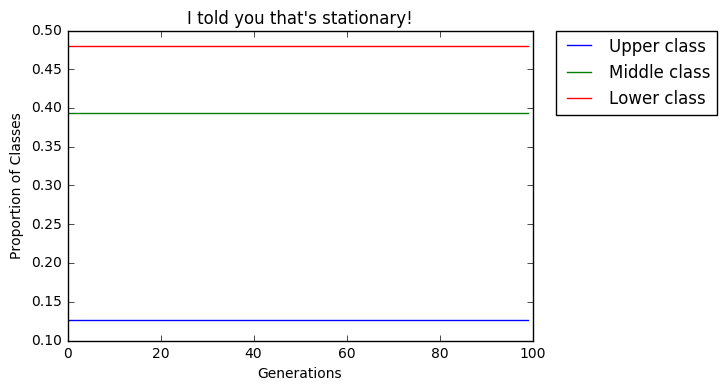

In [3]:
import matplotlib.pyplot as plt

gary_generations = gary.copy()
for i in range(100):
    gary = np.dot(gary, transition_p);
    gary_generations = np.vstack( (gary_generations, gary)  )
plt.plot(gary_generations[range(100), 0 ], label = "Upper class")
plt.plot(gary_generations[range(100), 1 ], label = "Middle class")
plt.plot(gary_generations[range(100), 2 ], label = "Lower class")
plt.xlabel('Generations') ; plt.ylabel('Proportion of Classes')
plt.title("I told you that's stationary!")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); 
plt.show()

##### Detailed Balance Condition

Why the proportion doesn't change any more? Because now it satisfies detailed balance condition, that every probability "goes out" equals the probabilities that "comes back". Let's look at cases for upper class.

In [4]:
p_upper_goingout = gary[0,0]* (transition_p[0,1] + transition_p[0,2])
print "Proportions going out from upper class: ", p_upper_goingout

p_upper_comingback = gary[0,1]*transition_p[1,0] + gary[0,2]*transition_p[2,0]
print "Proportions coming back to upper class: ",p_upper_comingback

Proportions going out from upper class:  0.0441919191919
Proportions coming back to upper class:  0.0441919191919


#### 1.2 Markov Trick for Bayesian Inference

In the introduction section, we mention generating samples from the posterior distribution using MCMC. How? 

##### Motivation
If we have our <font color = 'red'>posterior as stationary distribution of a Markov Chain</font>, then we can generate as many samples as we want from the posterior distribution. (If you want to know more about sampling from Markov Chain, please visit <a href = 'http://setosa.io/blog/2014/07/26/markov-chains/index.html'> here</a>.) This is key idea of MCMC algorithm!

###### Posterior Distribution as Stationary Distribution
Suppose we have:
$$ h(θ, X)$$
where
$$ Parameters_ {unknown}:θ = {θ1,...,θk}  $$
$$ variables_ {known}: X = {X1,...,Xn}  $$
 
<br>
Writing it in a Bayesian fashion, 
 
$$ p(\mathbf{θ}|\mathbf{Y, X}) \propto p(\mathbf{Y}|\mathbf{θ, X}) \times p(θ) $$

Here, p(θ|Y,X) is our function of interest. Let's make it our stationary distribution.

##### Evolving Regardless of Initial State
Note that, once we have the correct transition matrix for the posterior distribution, regardless of what value of θ we start with, we will always guarantee that - samples we generate belong to the posterior distribution once we iterate enough times and reach stationary distribution. Then how many time should we iterate? We don't know! But most likely, iterating 10000 is enough; and we then could simply abondom the first thousands of samples that are generated before we reach stationary distribution.

However, there is one question remains, what should the transition matrix be?

### PART II: MARKOV CHAIN MONTE CARLO

<font color = 'red'>MCMC is to perform monte carlo for a Markov Chain whose stationary distribution is our posterior integral in our Bayesian inference.</font> In the previous section we have a glance at how Markov Chain relates to posterior distribution of interest; now we will look at how to construct transition matrix.

#### 2.1 Intuition from Reject Sampling

Look at the distribution below. How can we sample from such a complex distribution (green line)? 

We can have a "wrapper" probability density function outside our target probability function, and generate samples from the wrapper function. Then we will use some tricks to determine whether we want this sample or not. 

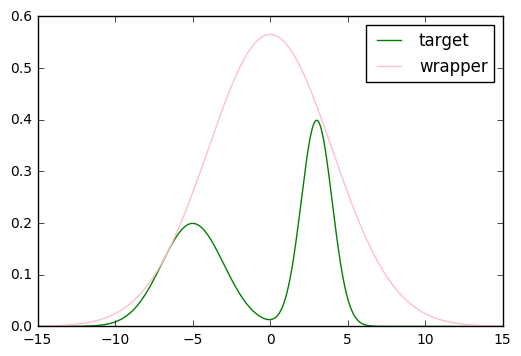

In [5]:
import scipy.stats as stat

# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(-15, 15, 0.001)
target_func = stat.norm.pdf(x_axis,3,1) + stat.norm.pdf(x_axis, -5, 2)
plt.plot(x_axis, target_func, color = 'green', label = 'target')

# wrapper function
wrapper_func = stat.norm.pdf(x_axis,0,4)
c =  np.max(target_func/wrapper_func)

#PLOT SCALED PROPOSAL/ENVELOP DISTRIBUTION
plt.plot(x_axis,c*wrapper_func, color = 'pink', label = 'wrapper');
plt.legend()
plt.show()

Steps for Reject Sampling are as follows:

* Sample from wrapper function, obtain X_i
* Calculate acceptance probability
$$α=\frac {p(x_i)} {Cq(x_i)}$$
* Compare acceptance probability with a random number between Uniform [0,1], say, u
* Accept X_i as a sample if α>= u, else reject X_i

Let's look at the below code to strengthen our understanding:

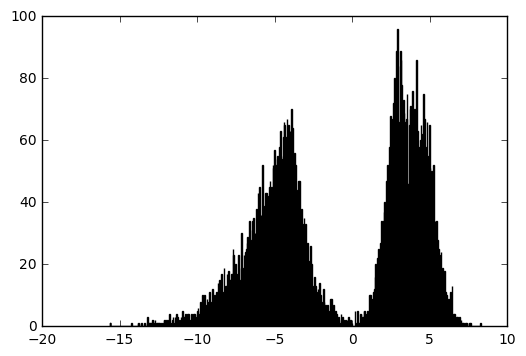

In [6]:
#probability of getting X at the target function;
def target_p(x):
    p = stat.norm.pdf(x,3,1) + stat.norm.pdf(x, -5, 2);
    return p;

#perform reject_sampling to get samples at size sampling_nums
def reject_sampling( sampling_nums):
    samples = []
    sample_num = 0;
    while(sample_num < sampling_nums):
        #sampling from wrapper function
        X_i = np.random.normal(0,4,1)[0];
        #calculate acceptance probability
            # q(X_i) is the probability of X_i given wrapper function; where loc = mean, scale = sigma (which isstdev, sqrt (4))
        a = target_p(X_i)/ (c*(stat.norm.pdf(X_i, loc=0, scale=2)));
        #compare with random value from Uniform 
        u = np.random.uniform(0,1,1);
        # if acceptance rate bigger than a random probability value, we accept X_i; vice versa
        if a>= u:
            samples.append(X_i);
            sample_num += 1;
        else:
            pass;
    return samples;

samples = reject_sampling(10000);

#plot the shistogram
plt.hist(samples, bins = 500, color = 'gray');
plt.show();

#### 2.2 A Transition Matrix with Acceptance Probability

Now let's assume we don't know the two means for the target function (we do know standard deviation), what can we do? 

$$ θ= mean1, mean2 $$ 
$$ p(\mathbf{θ}|\mathbf{samples}) \propto p(\mathbf{samples}|\mathbf{θ}) \times p(θ) $$

In continuous cases, transition matrix is just how we update our target distribution, which is θ in our case. 
Remember, we need to satisfy the detailed balance condition, where
$$p(θ_{proposed}|samples) P(θ_{original}|θ_{proposed})= p(θ_{original}|samples)P(θ_{proposed}|θ_{original}) $$
But most likely, this equation doesn't hold. 

What we can do? We multiply the right half with acceptance probability a, where 
\begin{align}
a & = \frac {equation_{left}} {equation_{right}}\\
  & = \frac {P(θ_{proposed}|samples) P(θ_{original}|θ_{proposed})}{P(θ_{original}|samples)P(θ_{proposed}|θ_{original})} 
\end{align}

Substitude posterior P(θ|samples) with its likelihood*prior, we then have:
\begin{align}
a  & = \frac {P(samples|θ_{proposed}) P(θ_{proposed})P(θ_{original}|θ_{proposed})}
{P(samples|θ_{original})P(θ_{original})P(θ_{proposed}|θ_{original})} \\
  & = \frac {P(samples|θ_{proposed}) P(θ_{original},θ_{proposed})}{P(samples|θ_{original})P(θ_{proposed},θ_{original})} \\
  & = \frac {P(samples|θ_{proposed}) }{P(samples|θ_{original})} \\
\end{align}

So the idea for the transition matrix for the posterior distribution of interest is pretty simple: <font color = 'red'>we propose a new θ as a random walk N(0,1) from the old θ; and then we decide to accept the new θ at probability a</font> if a < 1; will just accept new θ if a >= 1.

In [13]:
##Learning purpose only. In last section we will have reproducible code

# log probability of getting X at the target function with mean1 and mean2;
# note: using log is only to avoid producing 0 denominator and numerator because sample no. is large
def target_p(mean1, mean2):
    p = np.sum(  np.log(stat.norm.pdf(samples,mean1,1) + stat.norm.pdf(samples,mean2, 2)));
    return p;

#perform mcmc to generate samples posterior distributions
# iterations means total iterations, burning means the number of iterations we will abandon in the end
def mcmc(iterations, burning):
    mean1 = 3;  #initial mean1
    mean2 = -3;  #initial mean2
    mean1_list = []; #to store mean1 samples
    mean2_list = []; #to store mean2 samples
    sample_num = 0; #valid samples so far
    p_samples_theta = target_p(mean1, mean2);#P(samples|θoriginal)
    
    while(sample_num < iterations):
        #random work: serve as transition matrix
        random_work = np.random.normal(0,3,2);  #we can make the step bigger so I use N(0,3)
        #proposed thetas
        mean1_proposed = mean1 + random_work[0] ;
        mean2_proposed = mean2 + random_work[1] ;
        #P(samples|θ_proposed)
        p_samples_theta_proposed = target_p(mean1_proposed, mean2_proposed);
        #calculate log acceptance probability
        a = p_samples_theta_proposed - p_samples_theta;
        #compare with random value from Uniform
        log_u = np.log(np.random.uniform(0,1,1));
        # if acceptance rate bigger than a random probability value, we accept X_i; vice versa
        if a>= log_u:
            mean1_list.append(mean1_proposed);
            mean2_list.append(mean2_proposed);
            sample_num += 1;
        else:
            pass;
    mean1_approximate = np.mean(mean1_list[burning:]);
    mean2_approximate = np.mean(mean2_list[burning:]);
    return [mean1_approximate, mean2_approximate];

mean1_approximate, mean2_approximate = mcmc(10000,3000);
print "true mean1: 3", "   estimation: ", mean1_approximate;
print "true mean2: -5",  "  estimation: ", mean2_approximate

true mean1: 3    estimation:  3.68754057967
true mean2: -5   estimation:  -4.80500118953


### PART III: CALCULATING RETURN ON INVESTMENT
<br>
Companies care about one thing: how much sales could be boosted if we spend this amount of money in advertisment? 

This question is answered by RoI figure: 
\begin{equation*}
\frac{Profits - Investment}{Investment}
\end{equation*}


Let's look at how we solve RoI for a juice company. <br>

#### 3.1 Backgrounds
JuicyJuice spent 10,000 dollars in their Pittsburgh market while they spent $0 in their Austin market on April 2016.

Sales follow certain degree of seasonal changes as in summer people prefer to drink juices while in winter they don't. Pittsburgh has a larger market and sales are also higher than that in Austin. Mainly, the sales in Pittsburgh are higher than Austin by around \$2000 or \$3000, but it also happens that the differences go up to \$4000 or go down to $1000 due to competitors' strategy or sports competitions.

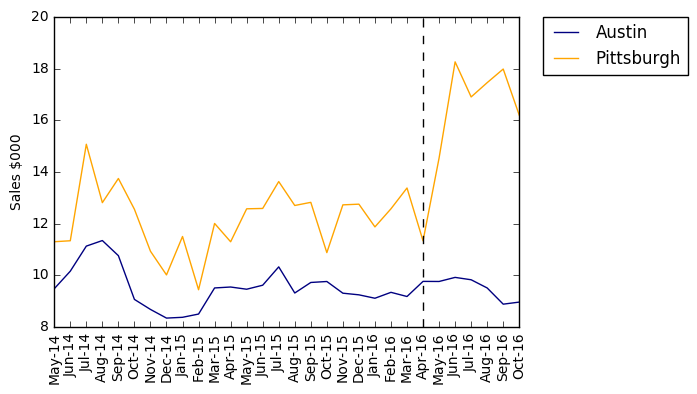

In [8]:
import numpy as np
from datetime import datetime as dt

np.random.seed(1349)

investment = 10000/1000

# sales of austin (in $1000) 
austin = np.array([ 9.4793,  10.1584,   11.1288,   11.3445,  10.7590,  9.0659,  8.6782,  8.3428,   8.3733,    8.4991,  9.5095,   9.5457,    9.4601,    9.6153,   10.3252, 9.3139,  9.7216,   9.7592,  9.3066,   9.2432,  9.1111,   9.3399,    9.1782,  9.7632,  9.7600, 9.9181,  9.8263,   9.5090,   8.8818,   8.9620])

#sales of pittsburgh (in $1000): 
pittsburgh = np.hstack(  (austin[:10] +   np.random.normal(2,1, 10), austin[10:20] + np.random.normal(3, 1, 10), austin[20:24]  +   np.random.normal(2,1, 4), 
                          austin[24:28] +  np.random.normal(2, 1, 4) + np.random.normal(5,1, 4), austin[28:] +   np.random.normal(3, 1, 2) + np.random.normal(5,1, 2)  ) )

#prepare x-axis labels denoting months
sd = dt.strptime('2014-5-10', "%Y-%m-%d") ; ed = dt.strptime('2016-10-10', "%Y-%m-%d") 
month = [dt.strptime('%2.2d-%2.2d' % (y, m), '%Y-%m').strftime('%b-%y') for y in xrange(sd.year, ed.year+1) 
       for m in xrange(sd.month if y==sd.year else 1, ed.month+1 if y == ed.year else 13)]

plt.xticks(range(len(month)), month)
locs, labels = plt.xticks()  #makes the months (string) corresponds to int axis
plt.setp(labels, rotation=90);  #rotate x axis strings to increase readability
         
#plot Austin and Pittsburgh sales correspondingly
plt.plot(range(len(month)), austin, label = "Austin", color = 'navy')
plt.plot(range(len(month)), pittsburgh, label = "Pittsburgh", color = 'orange')

#plot advertisement time point as a vertical line
plt.axvline(x=23,color='k',ls='dashed'); 

#labels and legend
plt.ylabel('Sales $000') ; 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); 
plt.show()

#### 3.2 Traditionally Difference-in-Difference Approach

Traditionally, we use diff-in-diff approach to measure RoI. We compare the sales of control market Austin and test market Pittsburgh and calculate:

\begin{align}
              & \quad Pittsburgh - Austin\\
Before-Ad-Period	& \quad        a\\
Post- Ad-Period    & \quad        b\\
Diff-in-Diff      & \quad      b-a  \\
\end{align}

In [9]:
#calculates sales differences of Austin and Pittsburgh before April 2016
diff_before_ad = np.sum(pittsburgh[:-7] - austin[:-7])

#calculates sales differences of Austin and Pittsburgh after April 2016
diff_after_ad  = np.sum(pittsburgh[-7:] - austin[-7:])

#estimate a "pure" amount of sales attribution that advertisement brings to JuicyJuice Pittsburgh market
attained_profits = diff_after_ad - diff_before_ad*7/len(austin)
print "RoI by Diff-in-Diff Approach",  round((attained_profits - investment)/ investment, 2)

RoI by Diff-in-Diff Approach 2.18


However, this approach assumes that a nature of static regression, and requires the sales differences of Austin and Pittsburgh before and after the ad period are **i.i.d**, i.e. independent and identically distributed from one distribution. However, after posting ads most likely the distribution of sales differences change, that means, <font color='red'>the assumption for Diff-in-Diff doesn't hold any more.</font> Therefore, the MCMC approach gives a much better solution.

#### 3.3 Bayesian Inference using MCMC

Let's note four facts from our JuicyJuice story that, 
* (1) Pittsburgh's market has certain degree of linear correlation, and is always larger than Austin's. 
* (2) Sometimes its competitor will go on some promotions, which results a fall of JuicyJuice's Pittsburgh sales. 
* (3) In the case 2, sales difference for the cities are mainly around \$2000, otherwise its's around \$3000.
* (4) Fluctuations for sales for Austin and Pittsburgh are alike, at most, it will \$1000.

(Note, though that's how I make the data so I know it :p
 but they are also easy to see if we calculate the mean, median and standard deviations of the two series).

Let's decompose our marketing understanding to some formulars that describe the two markets:

\begin{align}
(1) \quad  & Sales_{Pittsburgh, t}  = b0_t + b1\times Sales_{Austin, t}\\  
(2)\quad  & p_t  ∝  Binomial(1, p)\\
(3)\quad  & b0_t  ∝  Gaussian (mean_1, std dev^2) \quad if \quad p_t = 1\\
(4)\quad  & b0_t  ∝  Gaussian (mean_2, std dev^2) \quad if \quad p_t = 0\\
\end{align}

###### Bayesian Expressions
Writing it in a Bayesian fashion, 
 
$$ p(\mathbf{θ}|\mathbf{Sales_{Pittsburgh}, Sales_{Austin}}) \propto p(\mathbf{Sales_{Pittsburgh}}|\mathbf{θ, Sales_{Austin}}) \times prior(θ) $$

where θ denotes a collection of the parameters, 
$$ θ = [b1, p, mean_1, mean_2, std dev^2] $$
<br> <br>

Let's now build model using PyMC

In [10]:
from pymc import deterministic,Normal, Uniform, Bernoulli, graph, MCMC, MAP

class mcmc_model:
    data = pittsburgh[:24]
    #2nd equation - binormial distribution with 0<=p<=1; 
    # As we have no preference over what value should we choose about p, so we use a uniform distribution
    p = Uniform("p", lower=0, upper=1)  
    bern = Bernoulli("bern", p=p, size=len(data))

    #Gaussian distribution in 3rd and 4th equation - Gaussian distribution;
    # both mean are bounded by the min and max difference of the Pittsburgh sales and Austin sales
    # standard deviation is again bounded by the difference
    diff = pittsburgh - austin
    mean1 = Uniform('mean1', lower=min(diff), upper=max(diff))
    mean2 = Uniform('mean2', lower=min(diff), upper=max(diff))
    std_dev = Uniform('std_dev', lower=0, upper= np.sqrt(max(diff) - min(diff)))
    
    #in order to formulate normal distribution in PyMC, we need its precision, which is 1/variance rather than stdev
    @deterministic(plot=False)
    def precision(std_dev=std_dev):
        return 1.0 / (std_dev * std_dev)
    
    b0_1  = Normal('b0_1', mu = mean1, tau=precision)
    b0_2 = Normal('b0_2', mu = mean2, tau = precision)
    
                                  
    # "model" the observed x values as a normal random variable
    # because x is observed, it doesn't actually matter how we choose to model x -- PyMC isn't going to change x's values
    X_austin = Normal('X_austin', mu = 0, tau = 1, value=austin[:24], observed=True)
    
    #As we have no preference for b1 value so we again choose a uniform value. 
    #As we could observe from graph that sales of Pittsburgh always large than that of Austin then we choose lower bound 1
    b1 = Uniform('b1', lower=1, upper=max(data)/min(X_austin))

    ## 1st equation 
    # if p = 1, then we will go for the random variable from the first gaussian distribution with mean_1
    # if p = 0, then we will go for the random variable from the second gaussian distribution with mean_2
    # the slope of the regression component is b1 and the observed variable is X_austin
    @deterministic(plot = False)             
    def pred(bern = bern, b0_1 = b0_1, b0_2=b0_2, b1 = b1, x=X_austin):
        return  bern *b0_1 + (1 - bern) * b0_2 + b1*x  
    
    # "model" the observed y values as a normal random variable
    # its mean is pred  and value is the data (pittburgh[:24])
    y = Normal('y', mu = pred, tau=precision, value=data, observed=True)

#formulate mcmc using the model
model = MCMC(mcmc_model)
#sample 10000 times and burn the first 8000
model.sample(iter=10000, burn=3000)
# create a MAP
model_map = MAP(model)
model_map.fit()

#put the coefficients together
coef = {}
for variable in model_map.variables:
    coef[str(variable)]= variable.value
#pymc.Matplot.plot(model)

 [-----------------100%-----------------] 10000 of 10000 complete in 11.2 secWarning: Stochastic bern's value is neither numerical nor array with floating-point dtype. Recommend fitting method fmin (default).


D:\Anaconda3\envs\py27\lib\site-packages\scipy\optimize\optimize.py:1881: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)


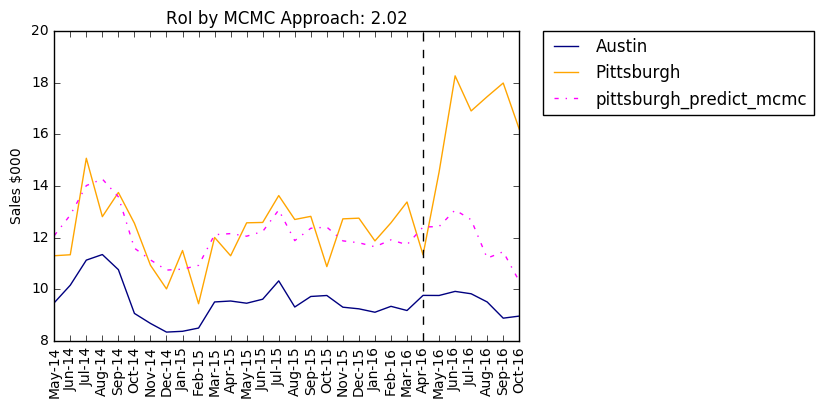

In [14]:
# prediction using the data
def prediction(data):
    binom = np.random.binomial(n = 1, p = coef['p'], size = len(data)) # equation 4
    stdev = np.sqrt (1/ coef['precision']) #equation 2&3
    mean1_rand = np.random.normal(coef['mean1'], stdev, size = len(data)) #equation 2
    mean2_rand = np.random.normal(coef['mean2'], stdev, size = len(data)) #euqation 3
    b1 = coef['b1']; # equation 1
    result = b1*data + binom*mean1_rand + (1-binom)*mean2_rand #equation 1
    return result

#putting the predictions for time preriod before the advertisement and predictions after the advertisement together
pittsburgh_pred = np.hstack(   (coef['pred'], prediction(austin[24:])  ))

#calculate ROI
RoI_mcmc = ( np.sum(pittsburgh[24:] - pittsburgh_pred[24:]) - investment)/investment

#plotting
plt.xticks(range(len(month)), month); locs, labels = plt.xticks();  #makes the months (string) corresponds to int axis
plt.setp(labels, rotation=90); #rotate x axis strings to increase readability
plt.plot(range(len(month)), austin, label = "Austin", color = 'navy'), plt.plot(range(len(month)), pittsburgh, label = "Pittsburgh", color = 'orange') #plot sales
plt.plot(range(len(month)), pittsburgh_pred, label= "pittsburgh_predict_mcmc", color = "magenta", linestyle = "dashdot" )
plt.axvline(x=23,color='k',ls='dashed'); #plot advertisement time point as a vertical line
plt.ylabel('Sales $000') ; plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); #labels and legend
plt.title('RoI by MCMC Approach: ' +  str( round(RoI_mcmc,2)))
plt.show()

What's going on here? We are creating a **counterfactual** prediction for sales in pittsburgh using MCMC - what will happen if the advertisement doesn't display in pittsburgh? 

This way is much more convincing and theoretically strong than the traditional diff-in-diff approach; worth to mention, it's advocated by Google [Ref 6].

### CONCLUSION

This tutorial aims to guide reader through Markov Chain, Reject Sampling to understand MCMC in detail. A business application case for MCMC is also given, where implementation using PyMC is also a reproducible case for future usage. 

Thank you for your time. Please contact yiyoulin@cmu.edu for any questions. :)

### REFERENCES
1. State space estimation in Python via Metropolis-Hastings http://www.chadfulton.com/posts/state_space_mh.html
* Markov Chain Monte Carlo (MCMC) https://people.duke.edu/~ccc14/sta-663/MCMC.html
* MCMC and Gibbs Sampling http://cos.name/2013/01/lda-math-mcmc-and-gibbs-sampling/
* Monte Carlo: Reject Sampling http://blog.csdn.net/baimafujinji/article/details/51407703
* PyMC Tutorial: https://pymc-devs.github.io/pymc/tutorial.html
* Google Causal Impact: https://github.com/google/CausalImpact
* Appendix: Markov Chain Monte Carlo: https://pymc-devs.github.io/pymc/theory.html